# Example of identifying relationships between neural activity and movement behavior in AJILE12

This script loads data directly from the DANDI remote repository using JupyterHub (https://hub.dandiarchive.org/). It can be adjusted to work on downloaded AJILE12 data files stored locally by using the commented out line in the cell after 'Load the data file' and commenting out all preceding lines in the cell.

In [1]:
# Uncomment and run this cell if using JupyterHub
# %pip install natsort
# %pip install seaborn
# %pip install nilearn
# %pip install dandi
# %pip install nwbwidgets==0.7.0
# %pip install git+https://github.com/catalystneuro/brunton-lab-to-nwb.git


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.signal import sosfiltfilt, butter, hilbert

from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events


## User-defined parameters

These parameters can be adjusted to analyze other electrodes, frequency bands, behavior types, participants, sessions, etc.

We will select data from participant 1, session 3 only during times that the participant was eating (because this is an active behavior). ECoG data will be converted to spectral power in the gamma band (80-100 Hz) for electrode 7, which is located over the motor cortex. We will also look at the vertical velocity of the right wrist.

In [3]:
sbj, session = 1, 3
behavior_type = 'Eat'
neural_freq_range = [80, 100]  # Hz
ecog_ch_num = 7
keypoint_of_interest = 'R_Wrist'
pose_direction = 'vertical'  # 'vertical' or 'horizontal'


## Load the data file

Data is loaded in directly from DANDI remote repository.

In [4]:
with DandiAPIClient() as client:
    asset = client.get_dandiset("000055").get_asset_by_path(
        "sub-{0:>02d}/sub-{0:>02d}_ses-{1:.0f}_behavior+ecephys.nwb".format(sbj, session)
    )
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)

io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')
# io = NWBHDF5IO(local_file_path, mode='r', load_namespaces=False)
nwb = io.read()


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Print information about selected electrode

In [5]:
nwb.electrodes[ecog_ch_num]


,x,y,z,imp,location,filtering,group,group_name,standard_deviation,kurtosis,median_deviation,good,low_freq_R2,high_freq_R2
id,,,,,,,,,,,,,,
7,-53.896469,-29.059873,62.709102,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x1402148...,GRID,45.422554,2.707063,37.685382,True,0.103835,0.055118


## Data pre-processing

Identify the start and stop times when the behavioral label of interest occurs.

In [6]:
min_len = 100  # (sec) only keep times when the given label appears for longer than this amount of time at once

coarse_labels = nwb.intervals['epochs'].to_dataframe()
coarse_labels = coarse_labels[coarse_labels['labels'].str.contains(behavior_type)]
coarse_labels['diff'] = coarse_labels['stop_time'] - coarse_labels['start_time']
coarse_labels = coarse_labels[coarse_labels['diff'] > min_len]
coarse_labels.reset_index(inplace=True, drop=True)


Load the corresponding ECoG data for each behavioral label chunk and convert to spectral power via the Hilbert transform.

In [7]:
filter_order = 4  # order of butterworth filter used to bandpass filter the ECoG data

neural_data = nwb.acquisition['ElectricalSeries'].data
sampling_rate = nwb.acquisition['ElectricalSeries'].rate  # (Hz) ECoG sampling rate
neural_power = []
for i in range(coarse_labels.shape[0]):
    # Identify the start/end indices for each continuous chunk of the given behavioral label
    start_t = int(coarse_labels.loc[i, 'start_time']*sampling_rate)
    end_t = int(coarse_labels.loc[i, 'stop_time']*sampling_rate)
    
    # Load data snippet
    neur_data_curr = neural_data[start_t:end_t, ecog_ch_num]
    
    # Bandpass filter
    sos = butter(filter_order, neural_freq_range, btype='bandpass', output='sos', fs=sampling_rate)
    neur_data_filtered = sosfiltfilt(sos, neur_data_curr)
    
    # Apply Hilbert transform and convert to decibels
    neur_pow = np.abs(hilbert(neur_data_filtered))
    neur_pow = 10*np.log(neur_pow)
    
    # Take the difference between neighboring timepoints
    neural_power.append(np.diff(neur_pow))


Load the corresponding pose data for each behavioral label chunk and convert to vertical velocity.

In [8]:
keypoints = list(nwb.processing['behavior'].data_interfaces['Position'].spatial_series.keys())
assert keypoint_of_interest in keypoints
assert pose_direction in ['vertical', 'horizontal']
keypoint_series = nwb.processing['behavior'].data_interfaces['Position'].spatial_series[keypoint_of_interest]
sampling_rate_keypoint = keypoint_series.rate  # Hz
keypoint_velocity = []
for i in range(coarse_labels.shape[0]):
    start_t = int(coarse_labels.loc[i, 'start_time']*sampling_rate_keypoint)
    end_t = int(coarse_labels.loc[i, 'stop_time']*sampling_rate_keypoint)
    
    # Load pose data snippet
    pose_data_curr = keypoint_series.data[start_t:end_t, :]
    pose_mag_curr = pose_data_curr[:, 1 if pose_direction == 'vertical' else 0]
    
    # Convert to velocity (delta X / delta t)
    velocity_curr = np.diff(pose_mag_curr)/(1/sampling_rate_keypoint)
    keypoint_velocity.append(velocity_curr)


## Align and combine neural and pose data into a pandas dataframe

In [9]:
assert len(neural_power) == len(keypoint_velocity)
measures_all = []
for i in range(len(neural_power)):
    # Neural power for the given chunk
    neur_curr = neural_power[i]
    l_neur = len(neur_curr)
    
    # Pose velocity for the given chunk
    accel_curr = keypoint_velocity[i]
    l_accel = len(accel_curr)
    
    # Downsample neural data to match pose data
    inds_split = np.array_split(np.arange(l_neur), l_accel)
    for j, inds in enumerate(inds_split):
        measures_all.append([neur_curr[inds].mean(), accel_curr[j]])

# Combine neural/pose data into a dataframe
df_measures_all = pd.DataFrame(np.asarray(measures_all), columns=['Neural power (dB)', 'Keypoint velocity (pixels/sec)'])

# Remove any NaN's
df_measures_all.dropna(inplace=True)

# Remove instances with velocity close to 0
df_measures_all = df_measures_all[(df_measures_all['Keypoint velocity (pixels/sec)'] > 100) |\
                                  (df_measures_all['Keypoint velocity (pixels/sec)'] < -100)]
        

## Results

### Print correlation between neural power and keypoint velocity

We find a small, positive correlation between neural power in the gamma band and right wrist vertical velocity.

In [10]:
df_measures_all.corr(method='pearson')

,Neural power (dB),Keypoint velocity (pixels/sec)
Neural power (dB),1.000000,0.025379
Keypoint velocity (pixels/sec),0.025379,1.000000


### Perform robust linear regression to quantify any linear relationships

Regression identifies a small, but significant (p<0.05) positive relationship between neural power in the gamma band and right wrist vertical velocity. This result makes sense because moving one's wrist upward takes more effort (fighting against gravity) than moving one's arm downward and thus may require slightly more cortical control.

In [11]:
X = df_measures_all['Keypoint velocity (pixels/sec)']
Y = df_measures_all['Neural power (dB)']

X = sm.add_constant(X)
rlm_model = sm.RLM(Y, X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
rlm_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:      Neural power (dB)   No. Observations:                 6447
Model:                            RLM   Df Residuals:                     6445
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 03 Feb 2022                                         
Time:                        08:26:34                                         
No. Iterations:                    16                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0075      0.006     -1.251      0.211      -0.019       0.004
Keypoint velocity (pixels/sec)  1.635e-05   6.62e-06      2.470      0.014    3.37e-06    2.93e-05
==================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### Plot data with linear fit

Most of the data appears clustered near 0 velocity. The positive relationship between neural power and right wrist vertical velocity is only barely visible. Additional steps that may help better understand the relationship between neural spectral power and wrist velocity include: removing pose data with abnormally high standard deviation due to noisy tracking, subtracting spectral power in nearby periods with minimal movement from ECoG spectral power, and manually reviewing pose trajectories to remove noisy tracking periods.

<AxesSubplot:xlabel='Keypoint velocity (pixels/sec)', ylabel='Neural power (dB)'>

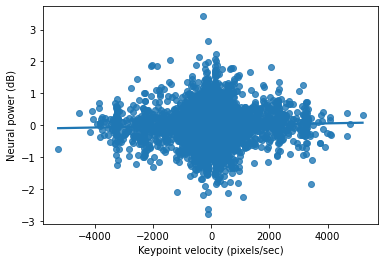

In [12]:
sns.regplot(data=df_measures_all, x='Keypoint velocity (pixels/sec)', y='Neural power (dB)', robust=True, ci=None)
